# Purpose

This notebook models conditional volatility using a GARCH framework, and evaluates its ability to forecast forward-looking risk relative to realised volatility, motivated by evidence of volatility clustering in ETF returns.

# Load libraries and data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [26]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()

returns = returns_df["adj_log_return"]

In [27]:
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.sort_index()

# Model motivation

Squared returns show significant autocorrelation

Volatility clustering is present

GARCH models time-varying conditional variance

Return-Volatility Correlation: 0.0050


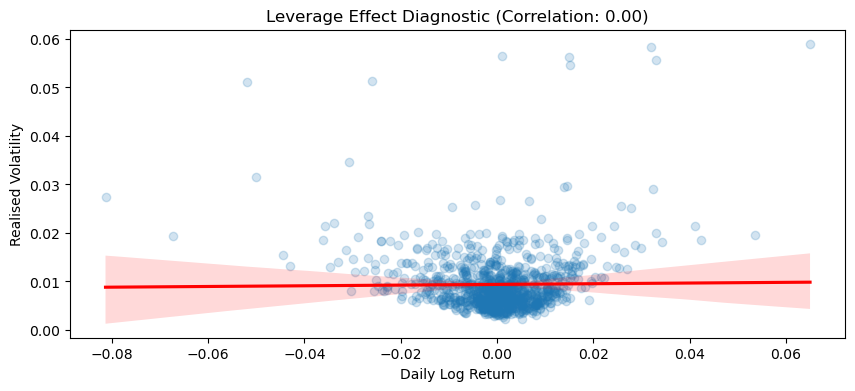

In [29]:
# Measure correlation between returns and volatility
leverage_corr = vol_df[["adj_log_return", "realised_vol_21d"]].corr().iloc[0,1]
print(f"Return-Volatility Correlation: {leverage_corr:.4f}")

# Visualise the relationship
plt.figure(figsize=(10, 4))
sns.regplot(data=vol_df.sample(1000), x="adj_log_return", y="realised_vol_21d", 
            scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title(f"Leverage Effect Diagnostic (Correlation: {leverage_corr:.2f})")
plt.xlabel("Daily Log Return")
plt.ylabel("Realised Volatility")
plt.show()

A correlation near zero indicates no linear relationship exists between daily log returns and 21-day realised volatility as currently measured.

A symmetric GARCH(1,1) is sufficient because no "leverage effect" was detected in the data pipeline.

# Train / test split

In [28]:
split_date = "2022-01-01"

train = returns.loc[returns.index < split_date]
test  = returns.loc[returns.index >= split_date]

GARCH is estimated on returns

Volatility is derived from conditional variance

# GARCH(1,1) specification

In [14]:
garch_model = arch_model(
    train * 100,          # scale for numerical stability
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)

garch_fit = garch_model.fit(disp="off")

A constant-mean specification is used given the weak autocorrelation in returns.

# In-sample diagnostics

In [15]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         adj_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3742.25
Distribution:                  Normal   AIC:                           7492.51
Method:            Maximum Likelihood   BIC:                           7516.56
                                        No. Observations:                 3020
Date:                Sat, Jan 10 2026   Df Residuals:                     3019
Time:                        23:22:11   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0893  1.307e-02      6.830  8.474e-12 [6.365e-02,  0.115]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0419  8.188e-03      5.117  3.106e-07 [2.585e-02,5.795e-02]
alpha[1]       0.1929  2.503e-02      7.707  1.291e-14     [  0.144,  0.242]
beta[1]        0.7704  2.305e-02     33.421 6.794e-245     [  0.725,  0.816]
============================================================================

Covariance estimator: robust
"""

α + β < 1

Persistence close to 1. High persistence is typical of equity index volatility and consistent with long memory in risk.

Positive parameters

# Conditional volatility (in-sample)

In [16]:
cond_vol = garch_fit.conditional_volatility

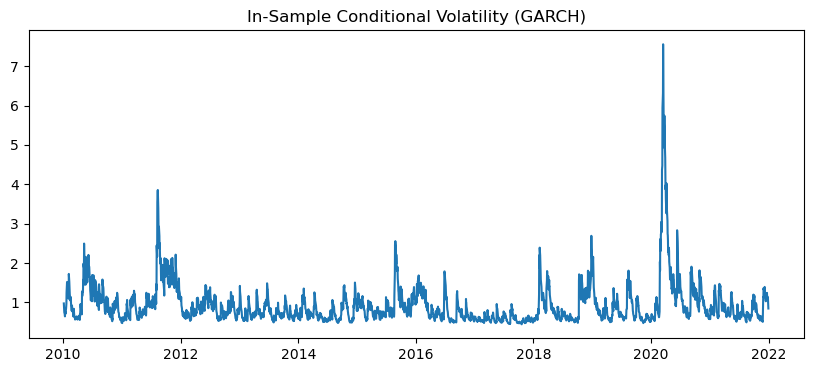

In [17]:
plt.figure(figsize=(10,4))
plt.plot(cond_vol)
plt.title("In-Sample Conditional Volatility (GARCH)")
plt.show()

This visually resembles realised volatility

# Out-of-sample volatility forecasting

In [18]:
history = train.copy()
garch_forecasts = []

for t in range(len(test)):
    model = arch_model(
        history * 100,
        mean="Constant",
        vol="GARCH",
        p=1,
        q=1,
        dist="normal"
    )
    fit = model.fit(disp="off")
    forecast = fit.forecast(horizon=1)
    
    var_forecast = forecast.variance.iloc[-1, 0]
    garch_forecasts.append(np.sqrt(var_forecast) / 100)
    
    history = pd.concat([history, test.iloc[t:t+1]])

The model is re-estimated at each step to reflect real-time updating, at the cost of computational efficiency.

In [19]:
garch_forecasts = pd.Series(
    garch_forecasts,
    index=test.index
)

# Compare GARCH volatility to realised volatility

In [20]:
realised_vol = vol_df.loc[garch_forecasts.index, "realised_vol_21d"]

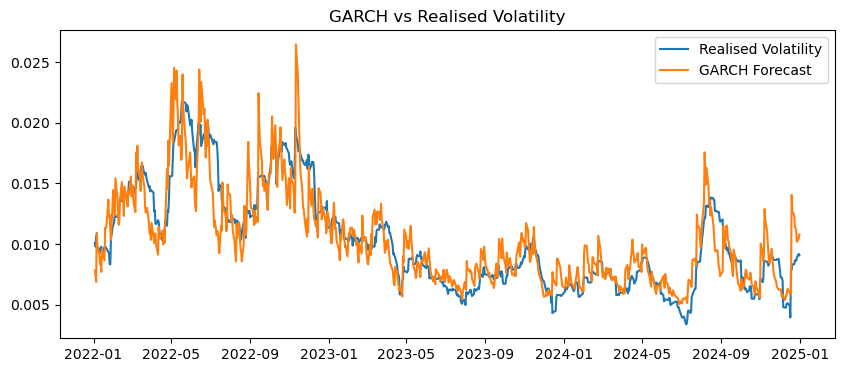

In [21]:
plt.figure(figsize=(10,4))
plt.plot(realised_vol, label="Realised Volatility")
plt.plot(garch_forecasts, label="GARCH Forecast")
plt.legend()
plt.title("GARCH vs Realised Volatility")
plt.show()

As expected:

+ Same regimes

+ Similar peaks

+ Slight timing differences

Realised volatility is backward-looking, while GARCH forecasts conditional variance based on information available at time t.

This reflects the forward-looking nature of GARCH variance forecasts compared to backward-looking realised volatility.

# Evaluation metrics

In [22]:
garch_mae = mean_absolute_error(realised_vol, garch_forecasts)
garch_rmse = root_mean_squared_error(realised_vol, garch_forecasts)

garch_mae, garch_rmse

(0.0014930654024753773, 0.0020256458297801235)

Errors reflect differences in horizon and construction between conditional volatility and rolling realised measures.

GARCH provides a structurally different estimate of volatility that captures conditional heteroskedasticity rather than smoothed realised risk.

# Interpretation

GARCH captures volatility clustering

Conditional variance reacts quickly to shocks

Forecasts are suitable for short-term risk monitoring

Not designed for precise volatility timing

GARCH is better suited for risk management and scenario analysis than point-forecast accuracy.

# Save forecasts

In [23]:
garch_forecasts.to_csv("../outputs/forecasts/garch_volatility_forecast.csv")